# Classic Risk Premia Portfolio Backtest

In this notebook we backtest a classic long-only portfolio of ETFs.

Profits are re-invested.

Rebalancing occurs ad-hoc when the asset weights exceed the target weights by a margin greater than the 'trade buffer'.

A minimum fixed commission per trade is modelled. In this scheme trading back to the ideal target weight is recommended.

Contrast with a percentage commission scheme where trading back to the buffer limit only is considered optimal.

In [51]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv('donotdelete.env')))

import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

import alphasim.stats
importlib.reload(alphasim.stats)
from alphasim.stats import calc_stats, calc_log_returns, calc_rolling_ann_vola


In [52]:
price_df = pdr.get_data_yahoo(['VTI', 'TLT', 'GLD'], start='2000-01-01').dropna()
price_df = price_df['Adj Close']
display(price_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,41.046688,50.798927,44.380001
2004-11-19,40.548504,50.393509,44.779999
2004-11-22,40.815372,50.656185,44.950001
2004-11-23,40.829613,50.718998,44.750000
2004-11-24,41.064480,50.718998,45.049999
...,...,...,...
2022-10-03,184.029999,103.830002,158.429993
2022-10-04,189.940002,103.540001,160.699997
2022-10-05,189.580002,102.550003,159.809998


In [53]:
weight_df = price_df.copy()
weight_df[:] = [0.6, 0.3, 0.1]
display(weight_df)

Symbols,VTI,TLT,GLD
Date,,,
2004-11-18,0.6,0.3,0.1
2004-11-19,0.6,0.3,0.1
2004-11-22,0.6,0.3,0.1
2004-11-23,0.6,0.3,0.1
2004-11-24,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [54]:
def fixed_min_commission(trade_price, trade_size):
    return 10

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_limit_trade_size=False, 
    commission_func=fixed_min_commission,
    initial_capital=10000,
    do_reinvest=True)

display(result)

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-18 VTI       41.046688         0.000000      0.000000        0.000000   
           TLT       50.798927         0.000000      0.000000        0.000000   
           GLD       44.380001         0.000000      0.000000        0.000000   
           cash       1.000000     10000.000000  10000.000000        1.000000   
2004-11-19 VTI       40.548504       146.175009   5927.177919        0.599780   
...                        ...              ...           ...             ...   
2022-10-06 cash       1.000000      2425.112845   2425.112845        0.062802   
2022-10-07 VTI      182.399994       121.030810  22076.019022        0.583551   
           TLT      100.989998       102.039495  10304.968382        0.272399   
           GLD      157.880005        19.156090   3024.363626        0.079945   
           cash       1.000000      2425.112845   2425.112845        0.064105   

                    target_weight  delta_weight  do_trade  adj_target_weight  \
datetime   Symbols                                                             
2004-11-18 VTI       6.000000e-01      0.600000      True           0.600000   
           TLT       3.000000e-01      0.300000      True           0.300000   
           GLD       1.000000e-01      0.100000      True           0.100000   
           cash      1.110223e-16     -1.000000     False           1.000000   
2004-11-19 VTI       6.000000e-01      0.000220     False           0.599780   
...                           ...           ...       ...                ...   
2022-10-06 cash      1.110223e-16     -0.062802     False           0.062802   
2022-10-07 VTI       6.000000e-01      0.016449     False           0.583551   
           TLT       3.000000e-01      0.027601     False           0.272399   
           GLD       1.000000e-01      0.020055     False           0.079945   
           cash      1.110223e-16     -0.064105     False           0.064105   

                    adj_delta_weight  trade_value  trade_size  commission  \
datetime   Symbols                                                          
2004-11-18 VTI                   0.6       6000.0  146.175009        10.0   
           TLT                   0.3       3000.0   59.056365        10.0   
           GLD                   0.1       1000.0   22.532672        10.0   
           cash                  0.0          0.0    0.000000         0.0   
2004-11-19 VTI                   0.0          0.0    0.000000         0.0   
...                              ...          ...         ...         ...   
2022-10-06 cash                  0.0          0.0    0.000000         0.0   
2022-10-07 VTI                   0.0          0.0    0.000000         0.0   
           TLT                   0.0          0.0    0.000000         0.0   
           GLD                   0.0          0.0    0.000000         0.0   
           cash                  0.0          0.0    0.000000         0.0   

                    end_portfolio  
datetime   Symbols                 
2004-11-18 VTI         146.175009  
           TLT          59.056365  
           GLD          22.532672  
           cash        -30.000000  
2004-11-19 VTI         146.175009  
...                           ...  
2022-10-06 cash       2425.112845  
2022-10-07 VTI         121.030810  
           TLT         102.039495  
           GLD          19.156090  
           cash       2425.112845  

[18012 rows x 13 columns]

In [55]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

58

price  start_portfolio        equity  current_weight  \
datetime   Symbols                                                              
2004-11-18 VTI       41.046688         0.000000      0.000000        0.000000   
           TLT       50.798927         0.000000      0.000000        0.000000   
           GLD       44.380001         0.000000      0.000000        0.000000   
2006-05-09 TLT       51.092358        59.056365   3017.328929        0.259083   
2006-05-12 GLD       71.120003        22.532672   1602.523683        0.140152   
2007-06-14 VTI       56.604961       146.175009   8274.230742        0.641559   
2007-11-09 VTI       54.295223       136.706014   7422.483555        0.558246   
2008-01-22 VTI       48.749802       146.931032   7162.858642        0.558092   
2008-03-19 TLT       64.514389        68.383020   4411.688774        0.341594   
2008-10-06 VTI       40.528816       157.964278   6402.105202        0.547401   
           TLT       67.696800        60.056469   4065.630776        0.347625   
2008-10-27 VTI       32.049248       173.142770   5549.095539        0.558884   
           TLT       66.078972        51.828679   3424.785851        0.344931   
2008-10-31 VTI       36.890354       185.880641   6857.202661        0.642476   
2008-11-19 VTI       30.517250       173.591578   5297.537609        0.541511   
2009-01-30 GLD       91.309998        16.077314   1468.019522        0.140130   
2009-02-23 VTI       28.689941       192.341444   5518.264773        0.552128   
2009-03-05 TLT       72.821251        45.077386   3282.591668        0.347799   
2009-04-03 VTI       32.720970       209.018190   6839.277959        0.641267   
2009-04-09 TLT       71.213875        38.882311   2768.960021        0.257765   
2009-06-01 VTI       36.902431       195.567373   7216.911575        0.644108   
           TLT       63.778316        45.253231   2886.174893        0.257591   
2009-12-28 VTI       45.051498       182.175046   8207.258816        0.640180   
2010-01-08 TLT       63.961872        52.703666   3371.025138        0.259676   
2010-06-07 VTI       42.637672       170.741068   7280.001729        0.559119   
2010-06-29 TLT       73.661972        60.887800   4485.115423        0.343303   
2010-11-15 TLT       69.484291        53.207570   3697.090274        0.259623   
2010-12-08 VTI       50.905434       183.225169   9327.156707        0.641588   
2011-08-04 VTI       50.238670       171.348406   8608.316060        0.558817   
2011-08-19 TLT       85.082283        61.482521   5231.073279        0.342819   
2011-09-22 VTI       47.064255       183.976331   8658.708917        0.552293   
2011-10-21 VTI       51.631596       199.868112  10319.509560        0.642135   
2013-01-25 VTI       65.009567       186.753462  12140.761772        0.641114   
2013-03-08 TLT       91.616295        53.803209   4929.250675        0.257784   
2013-06-21 VTI       69.392479       174.777170  12128.221104        0.642564   
2013-11-21 VTI       79.336319       163.199738  12947.666475        0.640308   
           TLT       83.807213        62.614362   5247.535178        0.259509   
2014-09-18 GLD      117.779999        11.473147   1351.307234        0.059893   
2015-01-15 TLT      113.802345        72.383972   8237.465796        0.344122   
2016-02-08 VTI       83.297295       152.926151  12738.334688        0.557033   
2016-11-09 VTI       99.958054       164.722191  16465.309640        0.645940   
2016-12-08 TLT      105.132126        63.103246   6634.178439        0.257589   
2017-10-05 VTI      120.585518       153.006942  18450.421339        0.640536   
2018-09-11 TLT      109.685829        73.492973   8061.137641        0.258866   
2018-09-13 VTI      139.756638       143.323865  20030.461493        0.640399   
2018-12-19 VTI      119.925011       134.282400  16103.818286        0.556704   
2018-12-24 TLT      113.196892        85.170953   9641.087146        0.345347   
2020-03-09 VTI      132.790421       144.725731  19218.1

In [56]:
stats = calc_stats(result)
display(stats)

,equity
start,2004-11-18 00:00:00
end,2022-10-07 00:00:00
rf,0.0
total_return,2.783046
cagr,0.077237
max_drawdown,-0.31752
calmar,0.243251
mtd,0.007779
three_month,-0.063372
six_month,-0.173492


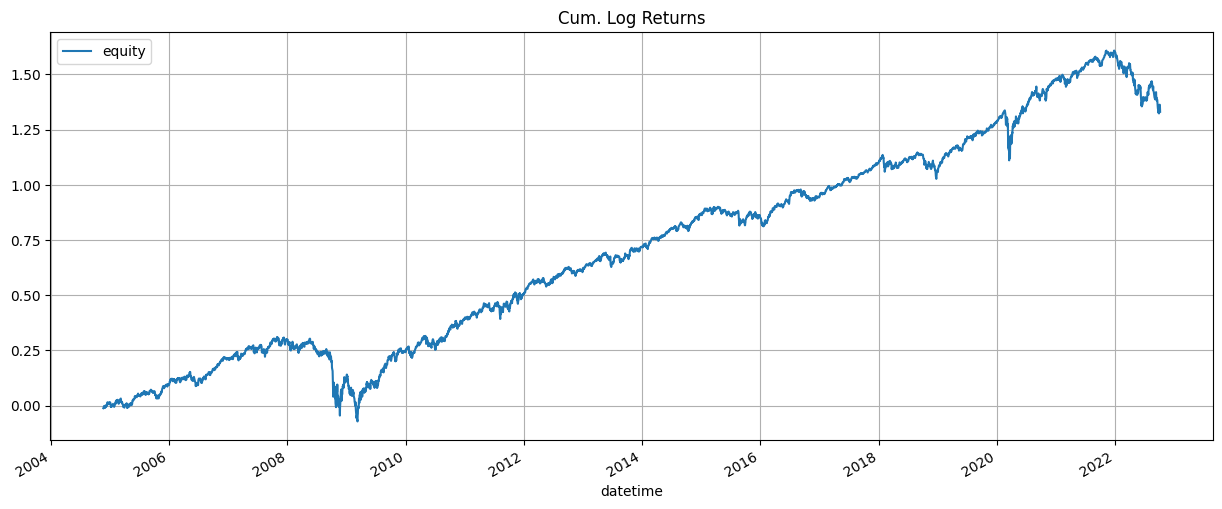

In [57]:
ax = calc_log_returns(result).cumsum().plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Log Returns')
plt.legend(loc=2)
plt.show()

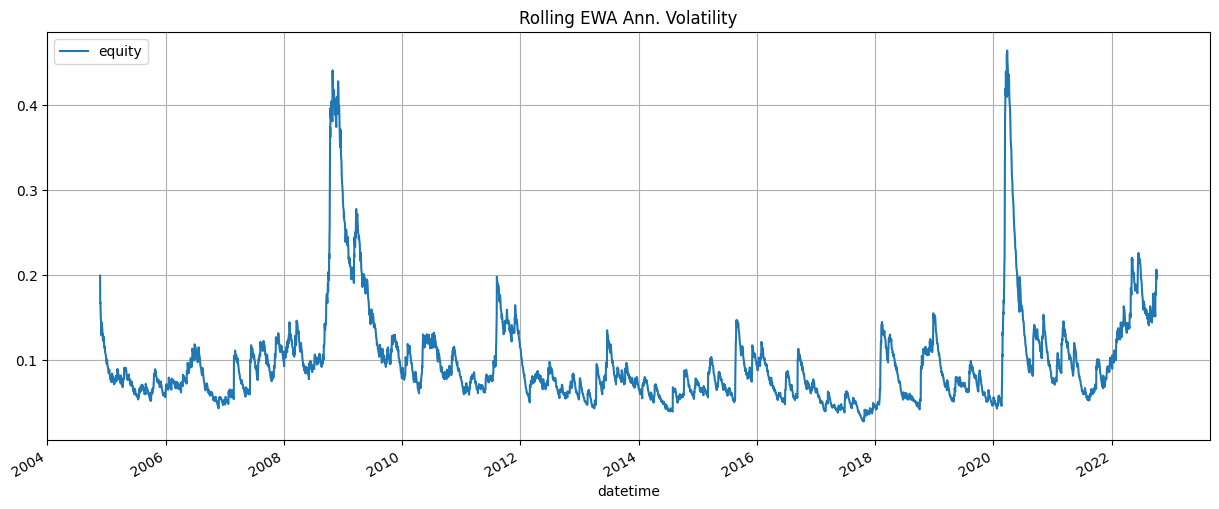

In [58]:
ax = calc_rolling_ann_vola(result).plot(figsize=(15, 6))
ax.grid(True)
plt.title('Rolling EWA Ann. Volatility')
plt.legend(loc=2)
plt.show()